In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
if ".." not in sys.path: sys.path.append("..")
from common import cosmology

In [9]:
def rhs(log_t, y, Gamma_phi):
    rho_phi, rho_tot, R = np.exp(y)
    t = np.exp(log_t)
    rho_rad = rho_tot - rho_phi
    T = cosmology.calc_temperature(rho_rad)
    H = cosmology.calc_hubble_parameter(rho_tot)
    d_log_R_d_log_t = t * H
    d_log_rho_phi_d_log_t = - t * (3 * H + Gamma_phi)
    d_log_rho_tot_d_log_t = - H * t * (4 - rho_phi / rho_tot)
    return (d_log_rho_phi_d_log_t, d_log_rho_tot_d_log_t, d_log_R_d_log_t)

In [10]:
def solve(H_inf, Gamma_phi):
    R0 = 1.0
    rho_phi_inf = cosmology.calc_energy_density_from_hubble(H_inf)
    t_start = 1 / H_inf
    start = np.log(t_start)
    #T_RH = cosmology.calc_reheating_temperature(Gamma_phi)
    t_end = 1 / Gamma_phi * 10 # T_RH**(-2)
    end = np.log(t_end)
    #steps = np.linspace(start, end, 50); steps[0] = start; steps[-1] = end
    sol = solve_ivp(rhs, (start, end), (np.log(rho_phi_inf), np.log(rho_phi_inf), np.log(R0)),
                   args=(Gamma_phi,), dense_output=True, rtol=1e-6)
    
    def T_fn(t):
        y = sol.sol(np.log(t))
        rho_phi, rho_tot, _ = np.exp(y)
        rho_rad = rho_tot - rho_phi
        T = cosmology.calc_temperature(rho_rad)
        return T
    
    def rho_rad_fn(t):
        rho_phi, rho_tot, _ = np.exp(sol.sol(np.log(t)))
        return rho_tot - rho_phi
    
    def rho_phi_fn(t):
        rho_phi, rho_tot, _ = np.exp(sol.sol(np.log(t)))
        return rho_phi
    
    return (t_start, t_end), T_fn, rho_rad_fn, rho_phi_fn

In [23]:
def plot(H_inf, Gamma_phi):
    (t_start, t_end), T_fn, rho_rad_fn, rho_phi_fn = solve(H_inf, Gamma_phi)
    ts = np.geomspace(t_start, t_end, 400)
    plt.loglog(ts, rho_rad_fn(ts))
    plt.axvline(7/6*t_start, color="k", ls="--")
    plt.xlabel("t * GeV")
    plt.ylabel("rho_phi / GeV^4")
    plt.title(f"H_inf = {H_inf:.2e} GeV, Gamma_phi = {Gamma_phi:.2e} GeV")
    plt.show()

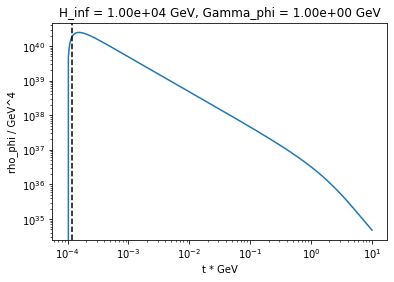

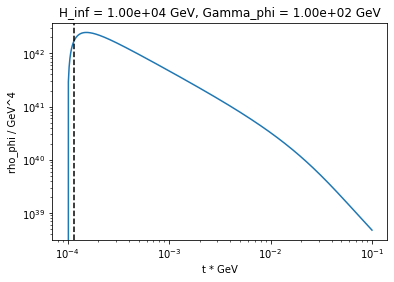

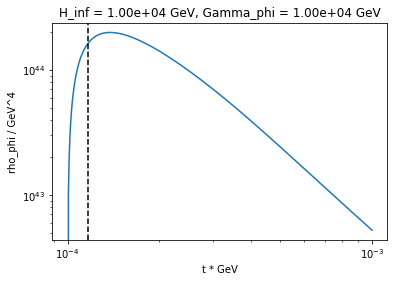

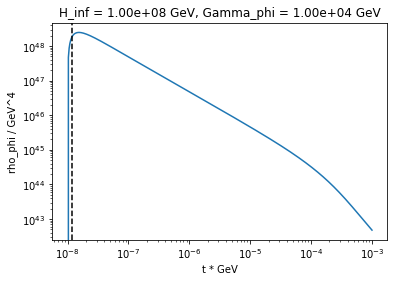

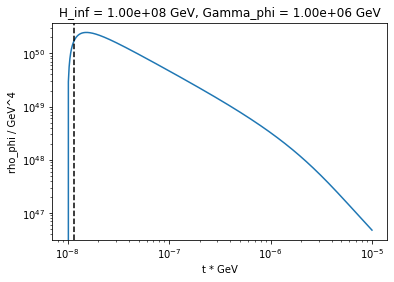

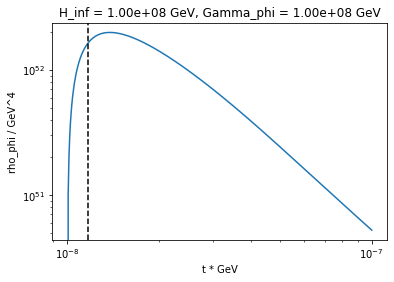

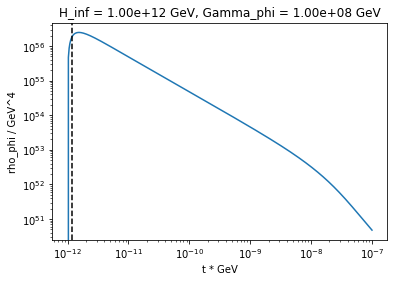

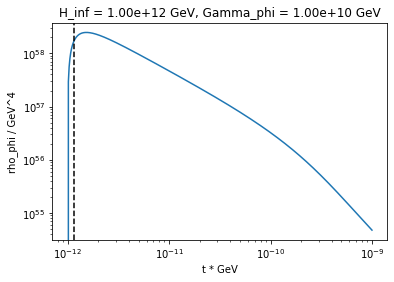

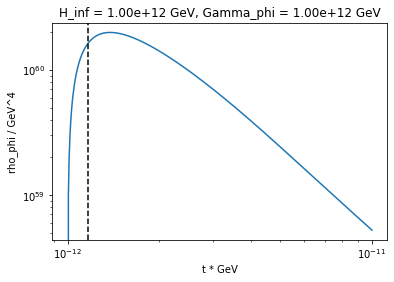

In [24]:
for H_inf in [1e4, 1e8, 1e12]:
    for r in [1e-4, 1e-2, 1]:
        Gamma_phi = r * H_inf
        plot(H_inf, Gamma_phi)

In [42]:
1 / (cosmology.M_pl / H_osc)

4.106776180698152e-10

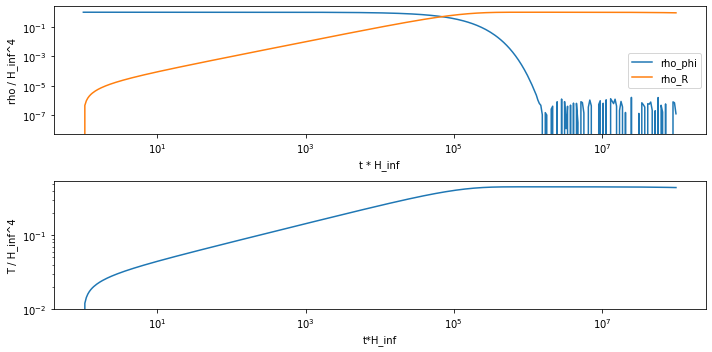

In [43]:
def rhs(t, y, Gamma, C):
    rho_phi, rho_R = y
    decay = Gamma*rho_phi
    H = np.sqrt(rho_phi + rho_R) * C
    return (-3*H*rho_phi - decay, -4*H*rho_R + decay)
H_osc = 1e9
Gamma_in_GeV = 1e4
Gamma = Gamma_in_GeV / H_osc
t_end = 1e3 * 1 / Gamma
M_pl = cosmology.M_pl / H_osc
C = 1 / (np.sqrt(3) * M_pl)
sol = solve_ivp(rhs, (1, t_end), (1.0, 0.0), args=(Gamma, C), t_eval=np.geomspace(1, t_end, 400), method="RK45")
assert sol.success
rho_phi, rho_R = sol.y


plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(sol.t, rho_phi, label="rho_phi")
plt.plot(sol.t, rho_R, label="rho_R")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("t * H_inf")
plt.ylabel("rho / H_inf^4")
D = (np.pi**2 / 45 * cosmology.g_star)
T = (rho_R / D)**(1/4)
plt.subplot(2,1,2)
plt.loglog(sol.t, T)
plt.xlabel("t*H_inf")
plt.ylabel("T / H_inf^4")
plt.tight_layout()

In [38]:
C

2.371048333427621e-10